<a href="https://colab.research.google.com/github/rajuzumaki2207/Time_series_Sequence/blob/main/RUL_TurboFan/2_TurboFan_RUL_dis_Lag_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sb



from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


In [3]:
## Train data
# define column names for easy indexing
index_names = ['id', 'cycles']
setting_names = ['op1', 'op2', 'op3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/train_FD001.txt", sep = "\s+", names=col_names)
test = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/test_FD001.txt", sep = "\s+", names =col_names)


In [4]:
train.head()

,id,cycles,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
y_test = pd.read_csv('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [6]:
def add_rul(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="id")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [7]:
## Add RUL
train = add_rul(train)

In [8]:
train.head()

,id,cycles,op1,op2,op3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:


def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, Variance:{}'.format(label, rmse, variance))

In [10]:
drop_sensors = ['sensor_1','sensor_5','sensor_6','sensor_10','sensor_16','sensor_18','sensor_19']
drop_labels = setting_names+drop_sensors

In [11]:
X_train = train.drop(drop_labels, axis=1)

In [12]:
X_test_int = test.drop(drop_labels, axis=1)

## Added Lagged variable

In this notebook we'll develop a distributed lag model to predict the Remaining Useful Life (RUL) of FD001.

In [13]:
# to make predictions homogeneous
np.random.seed(42)

In [14]:
rem_sensors = X_train.columns.difference(index_names+ ["RUL"])

In [15]:
lag1 = [col + "lag_1" for col in rem_sensors]

In [16]:
X_train[lag1] = X_train.groupby('id')[rem_sensors].shift(1)
X_train.dropna(inplace=True)

In [17]:
X_test_int[lag1] = X_test_int.groupby('id')[rem_sensors].shift(1)
X_test_int.dropna(inplace=True)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


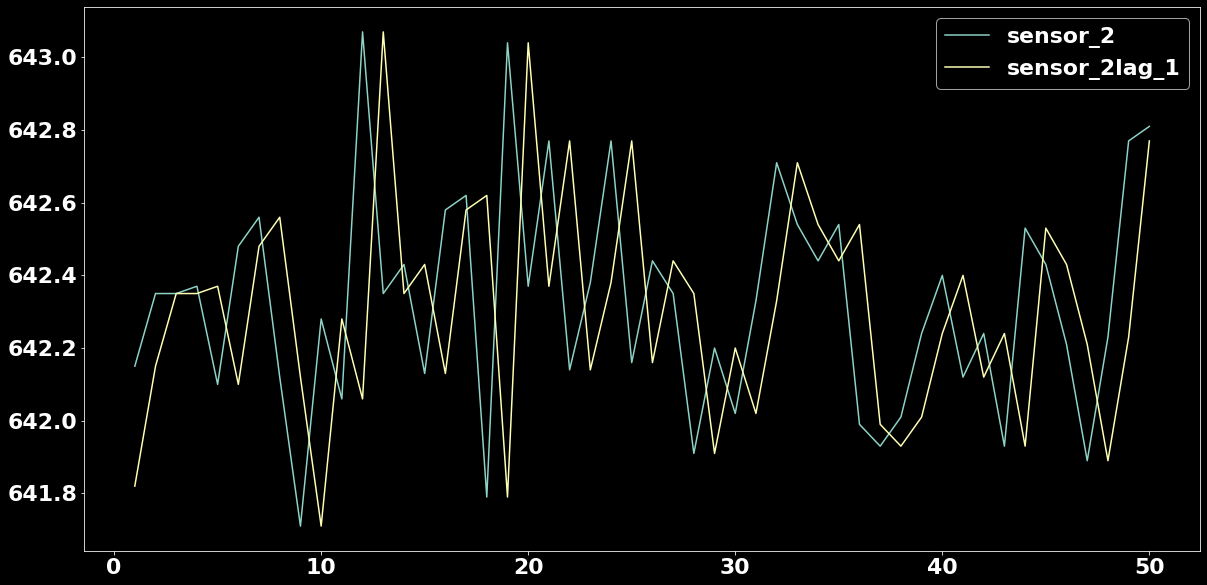

In [18]:
X_train[["sensor_2","sensor_2lag_1"]][0:50].plot() # visualizar lag of 1 for a sensor

In [19]:
## y_train
# target variable
y_train = X_train.pop('RUL')

In [20]:
X_test = X_test_int.groupby('id').last().reset_index()

In [21]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [22]:
# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')


train set RMSE:39.367692351135105, Variance:0.6709929595362321


In [23]:
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

test set RMSE:31.423109839704228, Variance:0.4282070678653923


<font color='Blue'>**Better than our basic regression Model with RMSE of 39 for test set ✌**

## Stationarity

Stationarity implies the statistical properties of the time series, such as mean and variance do not change over time, in addition the covariance (spread of the time series) should not be dependent on time (see figure below).

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


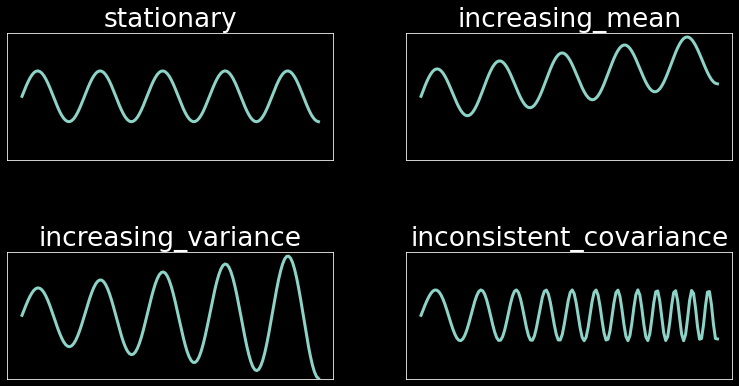

In [24]:
t = np.arange(0,150)
factor = 0.2
stationary = np.sin(factor*t)
increasing_mean = np.sin(factor*t) + t/100
increasing_variance = np.sin(factor*t) * (1 + t/100)
inconsistent_covariance = np.sin((factor + t/500) * t)

plotlist = [stationary, increasing_mean, increasing_variance, inconsistent_covariance]
plotnames = ['stationary', 'increasing_mean', 'increasing_variance', 'inconsistent_covariance']  # not very elegant but gets the job done

plt.subplots(2, 2, figsize=(12,7))  # initiate subplot figure
ylim = 2.5

for i in range(len(plotlist)):

    plt.subplot(2, 2, i+1)  # define which subplot to fill, range starts at 0 so increment with 1
    plt.plot(t, plotlist[i], linewidth=3)
    plt.ylim(-ylim, ylim)
    plt.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)  # remove axis ticks and labels
    plt.title(str(plotnames[i]))

plt.tight_layout(pad=3)  # specify layout and whitespace padding between graphs
plt.show()

## AD Fuller
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.

The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series

In [25]:
# test stationarity using adfuller test
from statsmodels.tsa.stattools import adfuller


adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(train[ 'sensor_7'], maxlag=1)
print('all units, single column test results')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}'.format(pvalue < 0.05))
print('NOTE: Testing one column has values of 100 engines, all engines together are stationary, but single engines are not!\n')

all units, single column test results
adf: -32.413164189329045 
pvalue: 0.0
Significant: True
NOTE: Testing one column has values of 100 engines, all engines together are stationary, but single engines are not!



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
train.loc[train['id']==1, 'sensor_7']

0      554.36
1      553.75
2      554.26
3      554.45
4      554.00
        ...  
187    551.94
188    550.70
189    551.29
190    550.92
191    551.25
Name: sensor_7, Length: 192, dtype: float64

In [27]:
test_series = train.loc[train['id']==1, 'sensor_7']
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series, maxlag=1)
print('single unit, single column test results')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

single unit, single column test results
adf: -2.2766669279481215 
pvalue: 0.17960380425355138
Significant: False



In [28]:
test_series 

0      554.36
1      553.75
2      554.26
3      554.45
4      554.00
        ...  
187    551.94
188    550.70
189    551.29
190    550.92
191    551.25
Name: sensor_7, Length: 192, dtype: float64

In [29]:
test_series_n = test_series.diff(1).dropna()
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series_n, maxlag=1)
print('single unit, single column test results after differencing')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

single unit, single column test results after differencing
adf: -14.824168539718967 
pvalue: 1.9431018596392618e-27
Significant: True



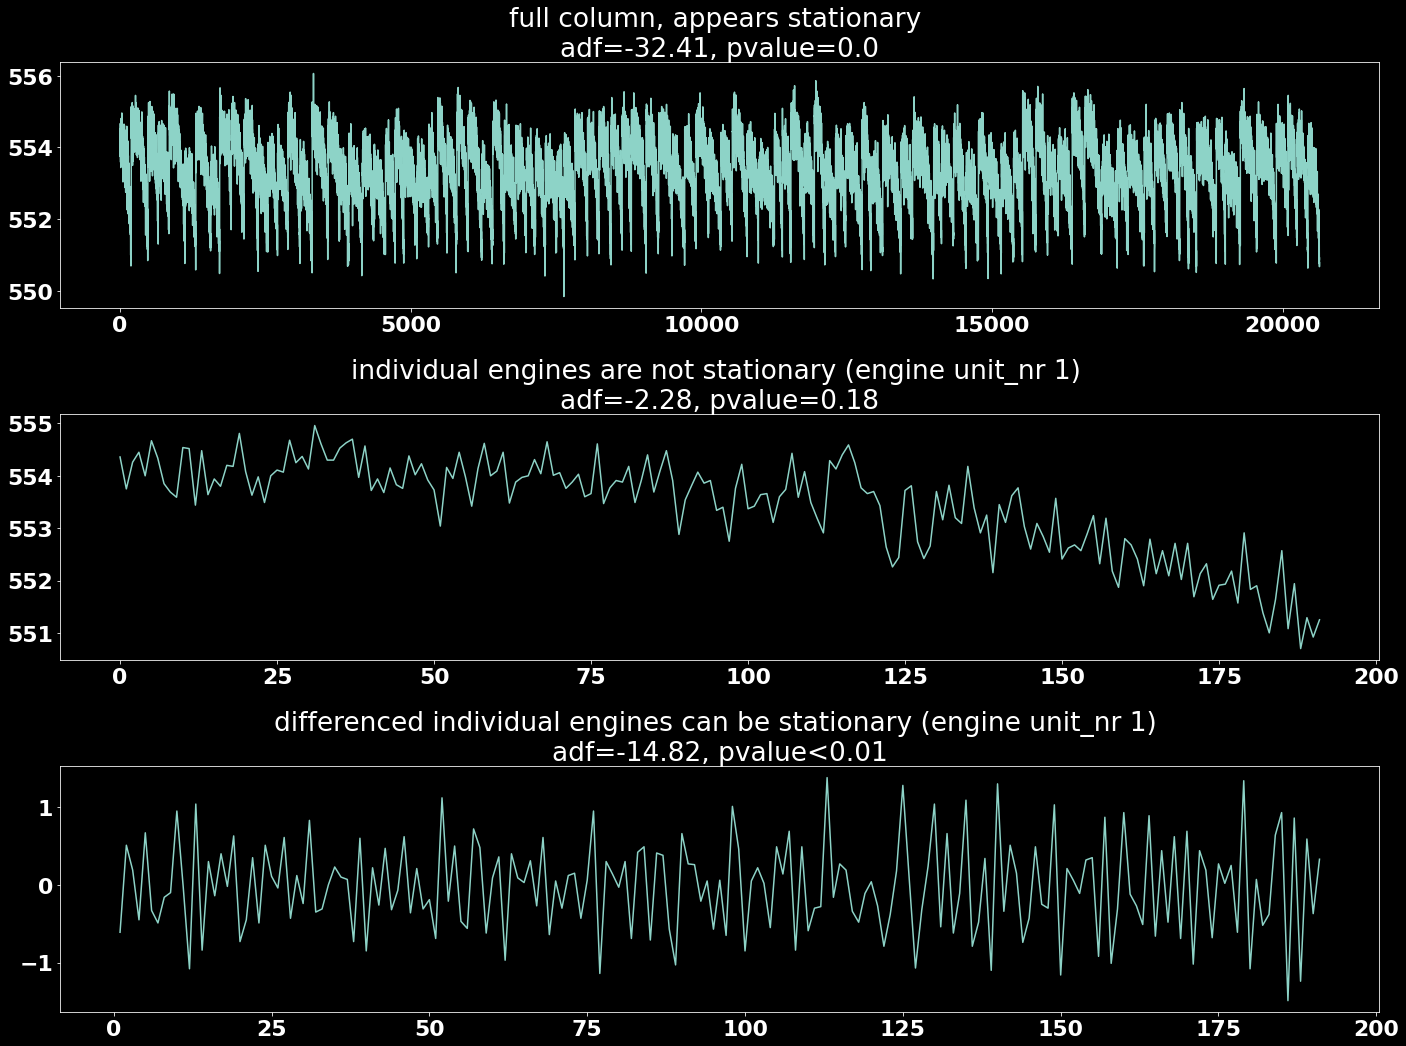

In [30]:
# full column vs single unit
plt.subplots(3,1, figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(train[ 'sensor_7'])
plt.title('full column, appears stationary \n\
adf=-32.41, pvalue=0.0')


plt.subplot(3,1,2)
plt.plot(train.loc[train['id']==1, 'sensor_7'])
plt.title('individual engines are not stationary (engine unit_nr 1) \n\
adf=-2.28, pvalue=0.18')


plt.subplot(3,1,3)
plt.plot(train.loc[train['id']==1, 'sensor_7'].diff(1).dropna())
plt.title('differenced individual engines can be stationary (engine unit_nr 1) \n\
adf=-14.82, pvalue<0.01')


plt.tight_layout()
plt.show()
# plt.close()

**From the above graph it is quite clear that individual units sensor data are not stationary. might be an idea to check what difference we need to take to make them stationary**

In [31]:
## For single unit of engine
unit_df = train[train["id"]==1] ## taking the frst engine


In [32]:
unit_df.drop(drop_labels + ["id", "cycles", "RUL" ], axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
unit_df.head()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [34]:
unit_df.columns

Index(['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_17', 'sensor_20', 'sensor_21'],
      dtype='object')

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
## function to check stionarity for unit engine 
def max_lag_for_engine(df):
  unit_df = df[df["id"]==i]
  unit_df.drop(drop_labels + ["id", "cycles", "RUL" ], axis=1,inplace=True)
  for col in unit_df.columns:
    max_diff = 0
    do = True
    adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(unit_df[col].diff(max_diff).dropna(), maxlag=1)
    if pvalue < 0.05:
      do = False

    while do:
      max_diff +=1
      adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(unit_df[col].diff(max_diff).dropna(), maxlag=1)
      if pvalue < 0.05:
        do = False
  return max_diff

In [48]:
def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff

In [66]:
print ("Max lag for engine ID 3 is " , find_max_diff(train.loc[train["id"]==3]["sensor_6"]))

Max lag for engine ID 3 is  0


In [69]:
find_max_diff(train.loc[train["id"]==3]["sensor_3"])

0

In [74]:
## Make the engine individually stationary
def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['id'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['id']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['id']==unit_nr, col] = df.loc[df['id']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

In [71]:
intermediate_df = train.drop(drop_labels, axis=1)

In [75]:
intermediate_df = make_stationary(intermediate_df, rem_sensors)

In [97]:
inter_col = intermediate_df.head().columns.difference(['id', 'cycles', 'RUL'])

In [99]:
def plot_station(df,id ,sensor):
  plt.subplots(2,1, figsize=(20,15))

  plt.subplot(2,1,1)
  plt.plot(df[str(sensor)])
  plt.title("Full column (All engines for the {}), appears stationary".format(sensor))


  plt.subplot(2,1,2)
  plt.plot(df.loc[df['id']==id][sensor])
  plt.title("Individual {} after differencing".format(sensor))


  

  plt.tight_layout()
  plt.show()

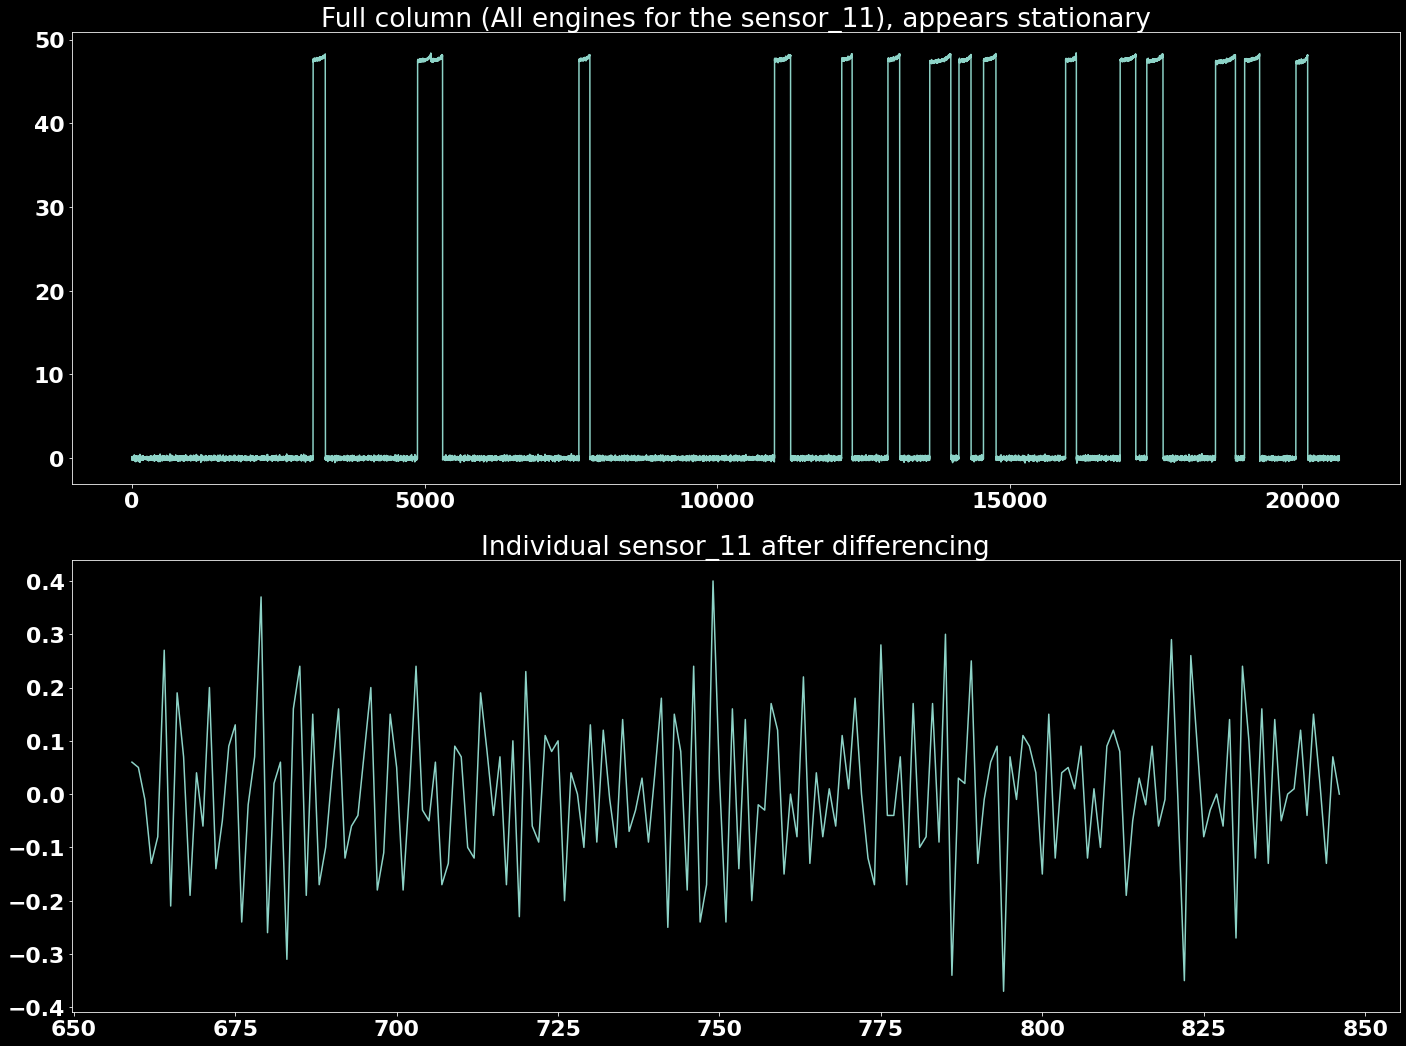

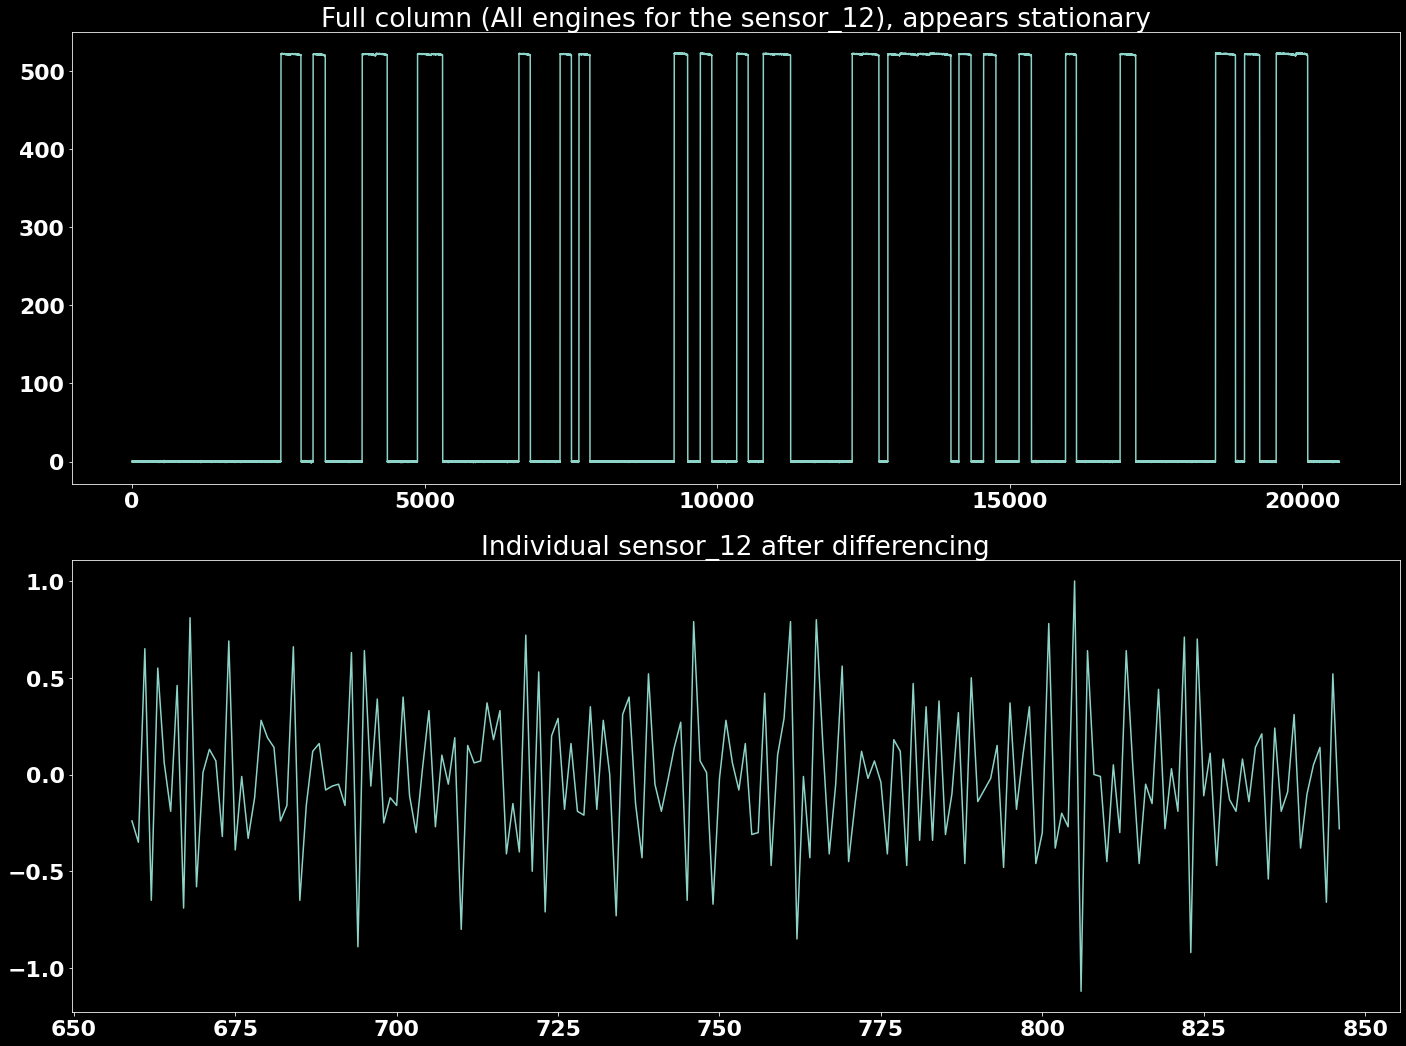

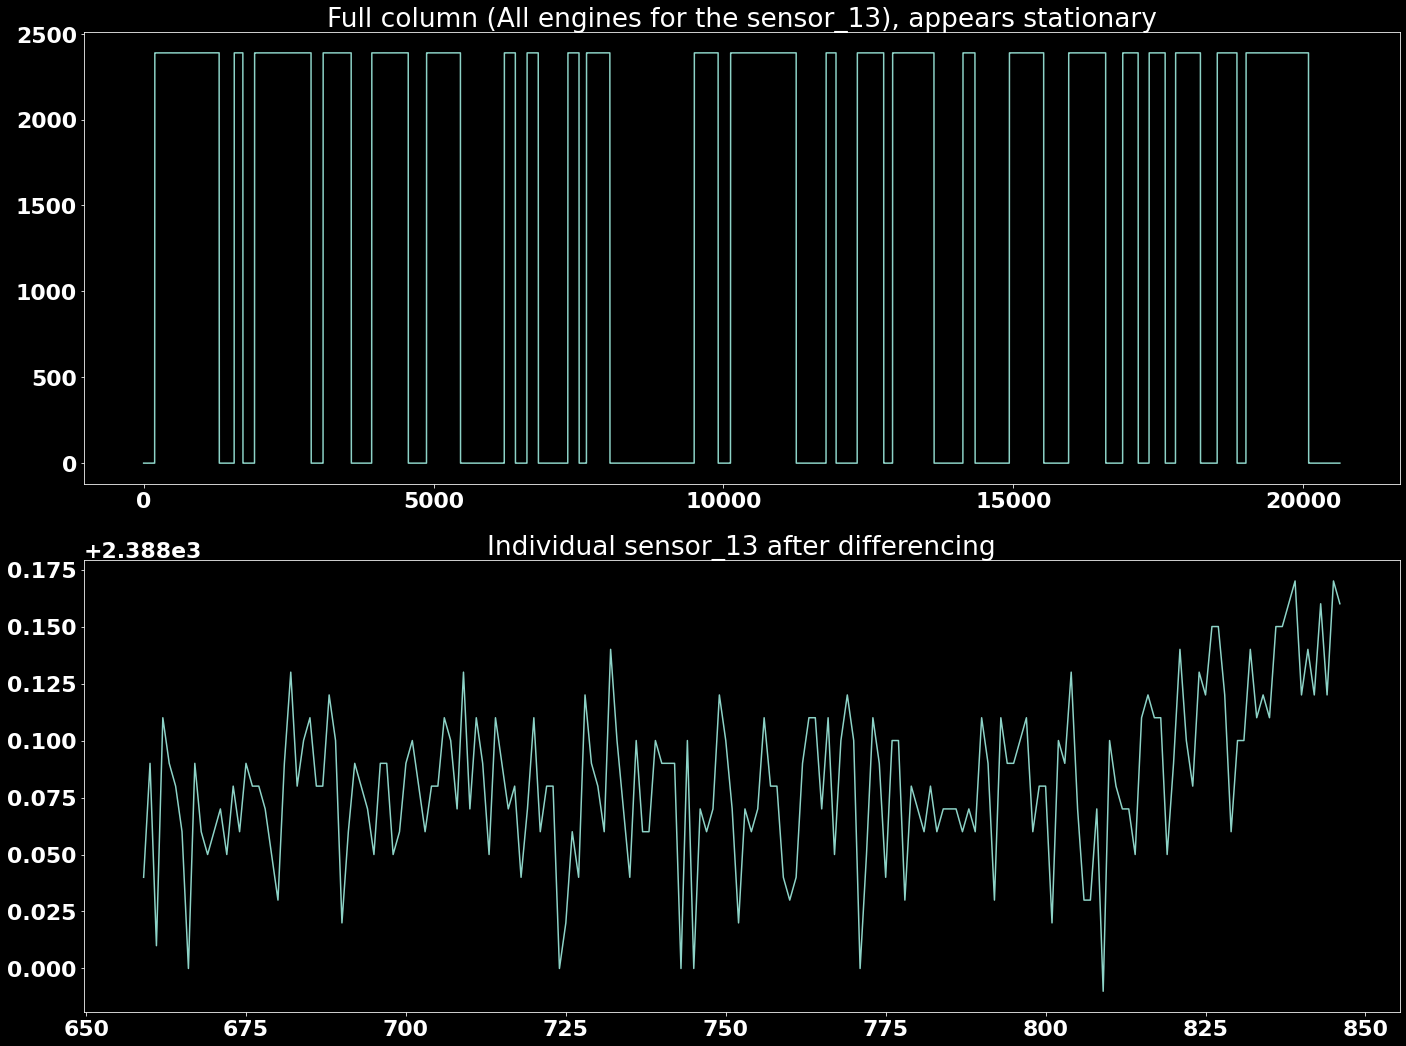

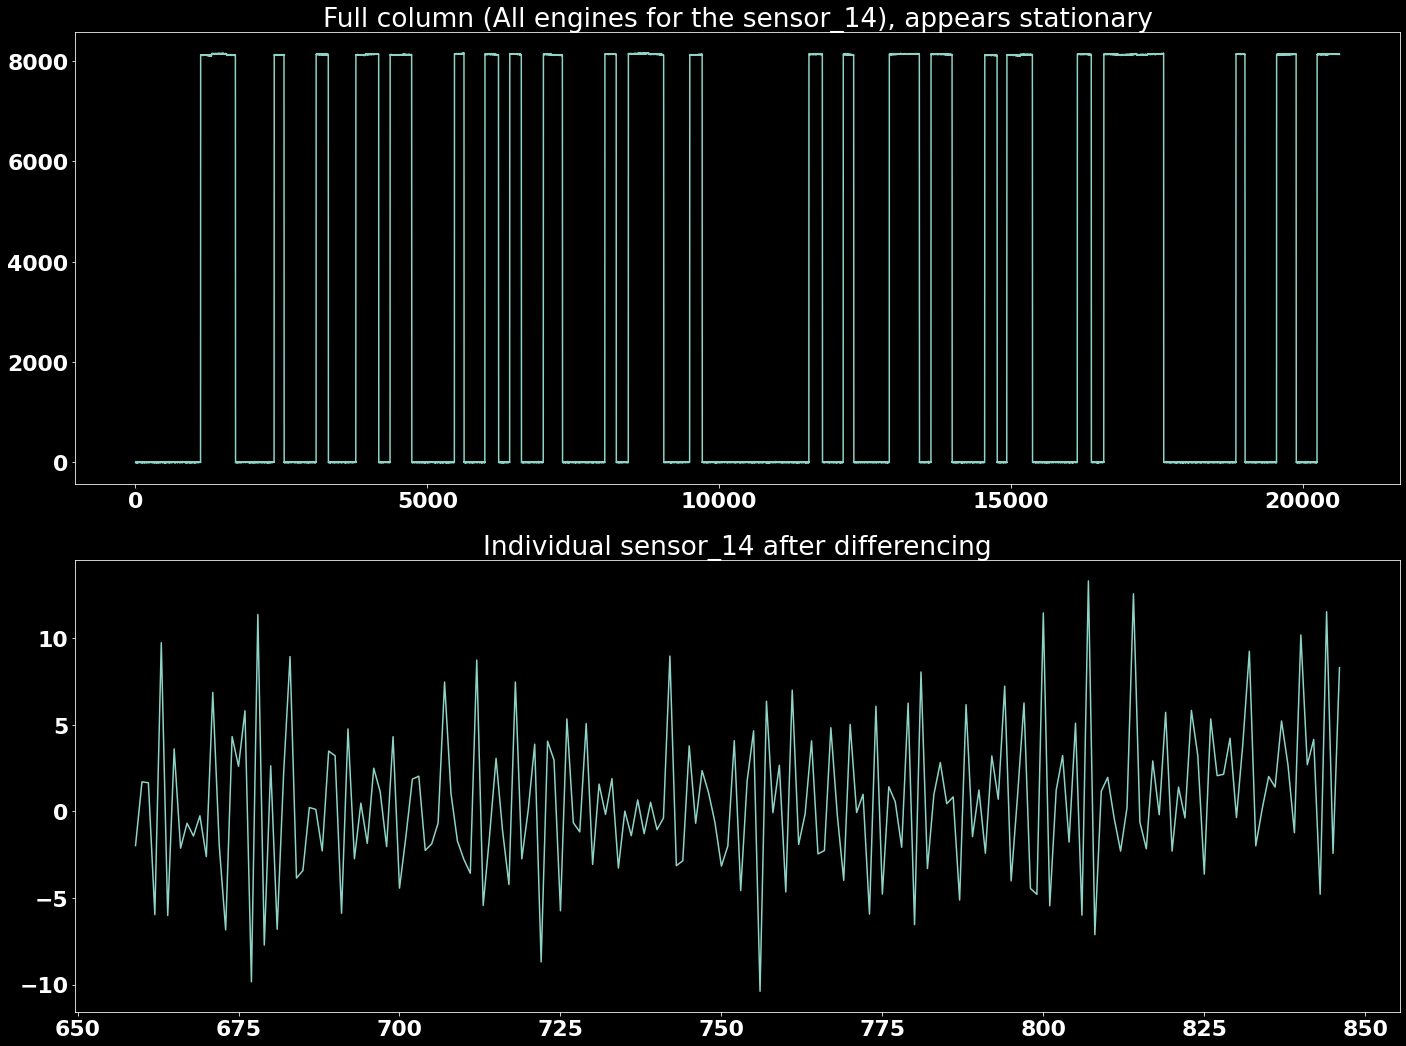

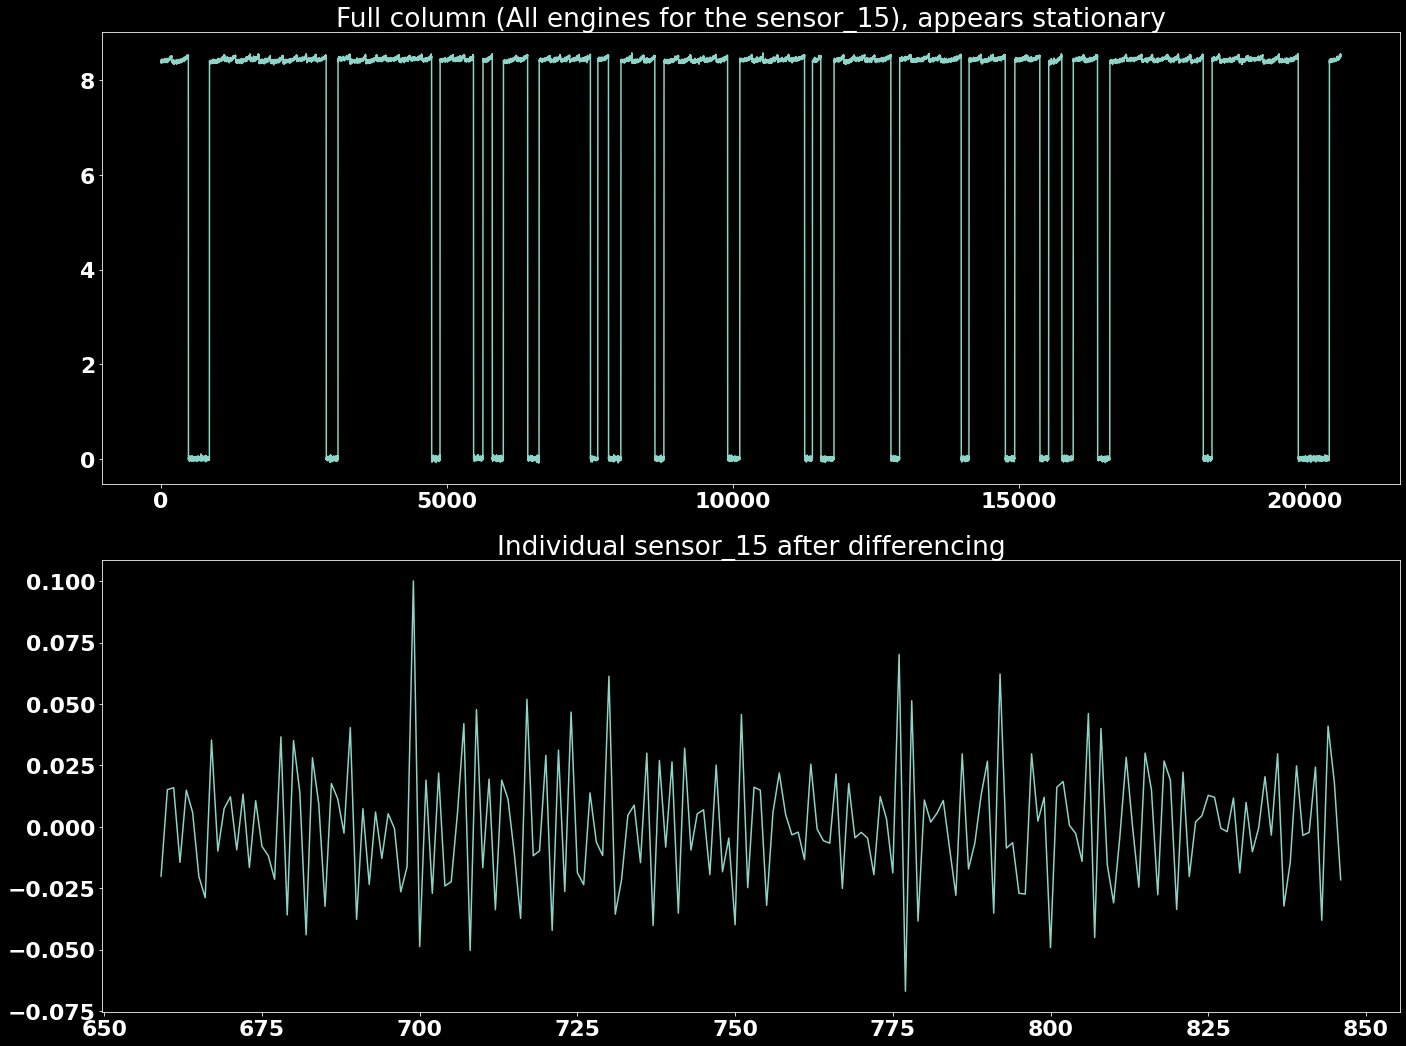

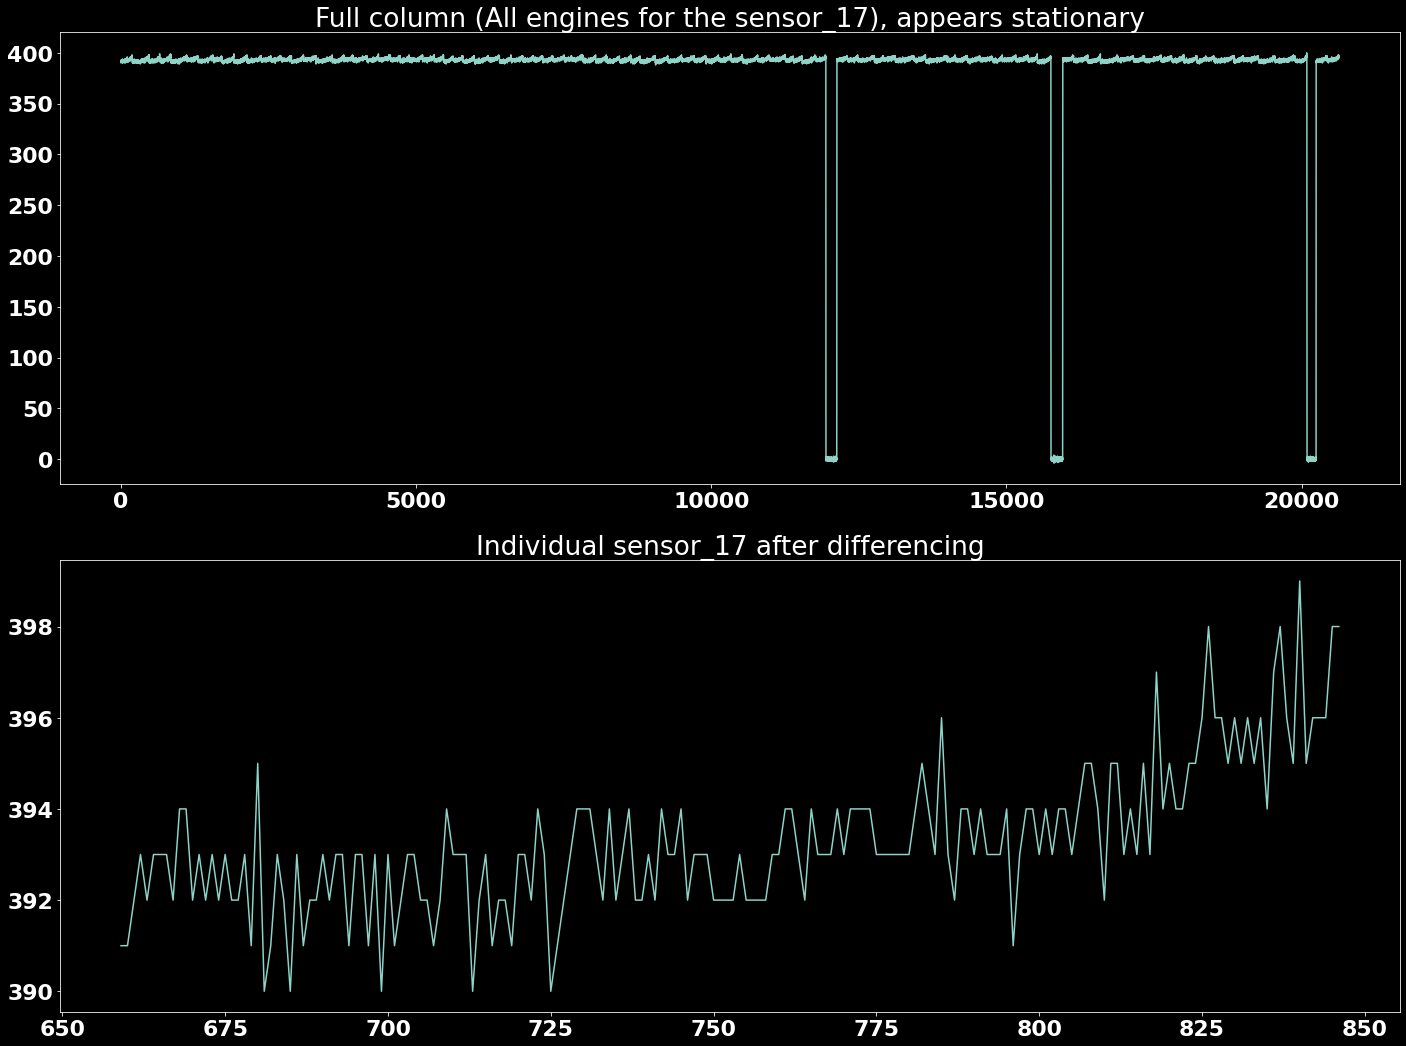

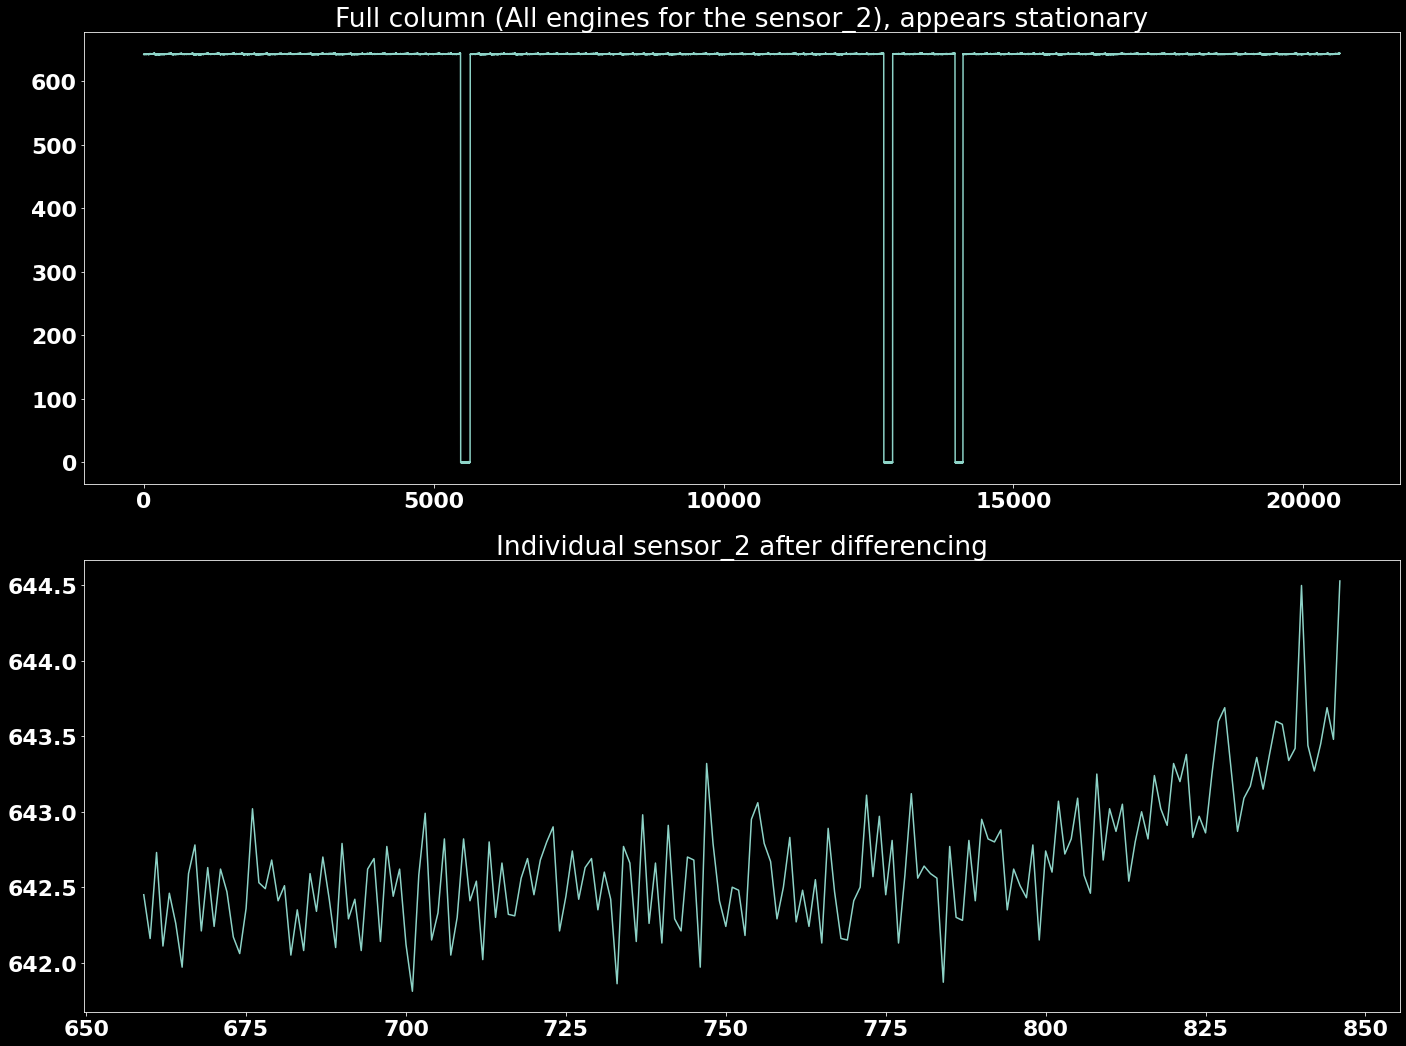

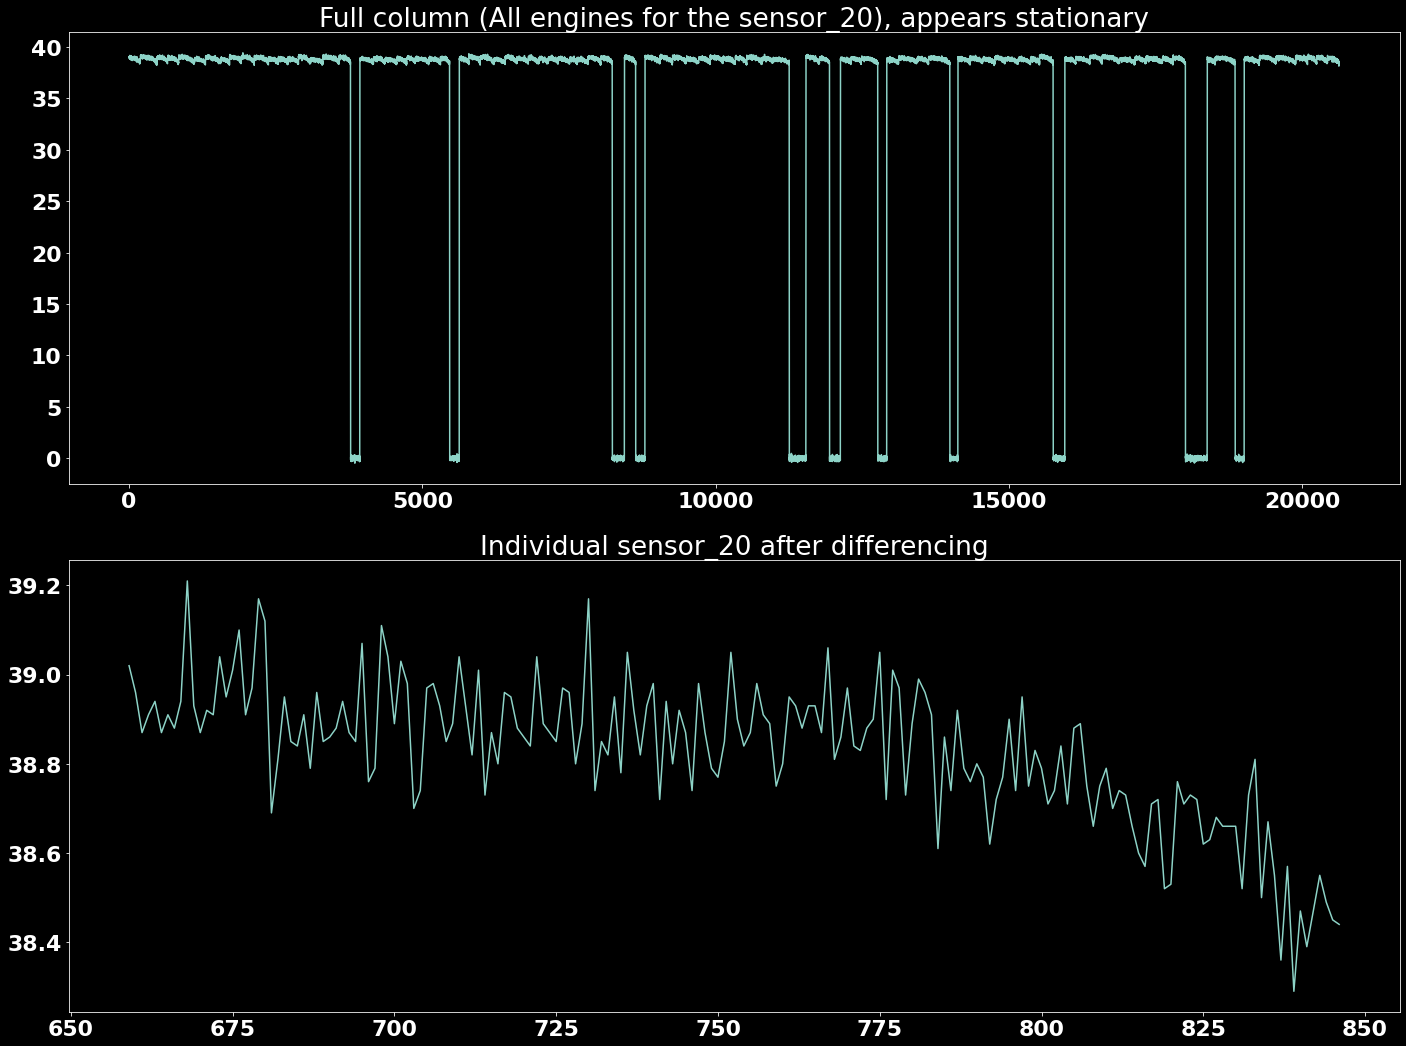

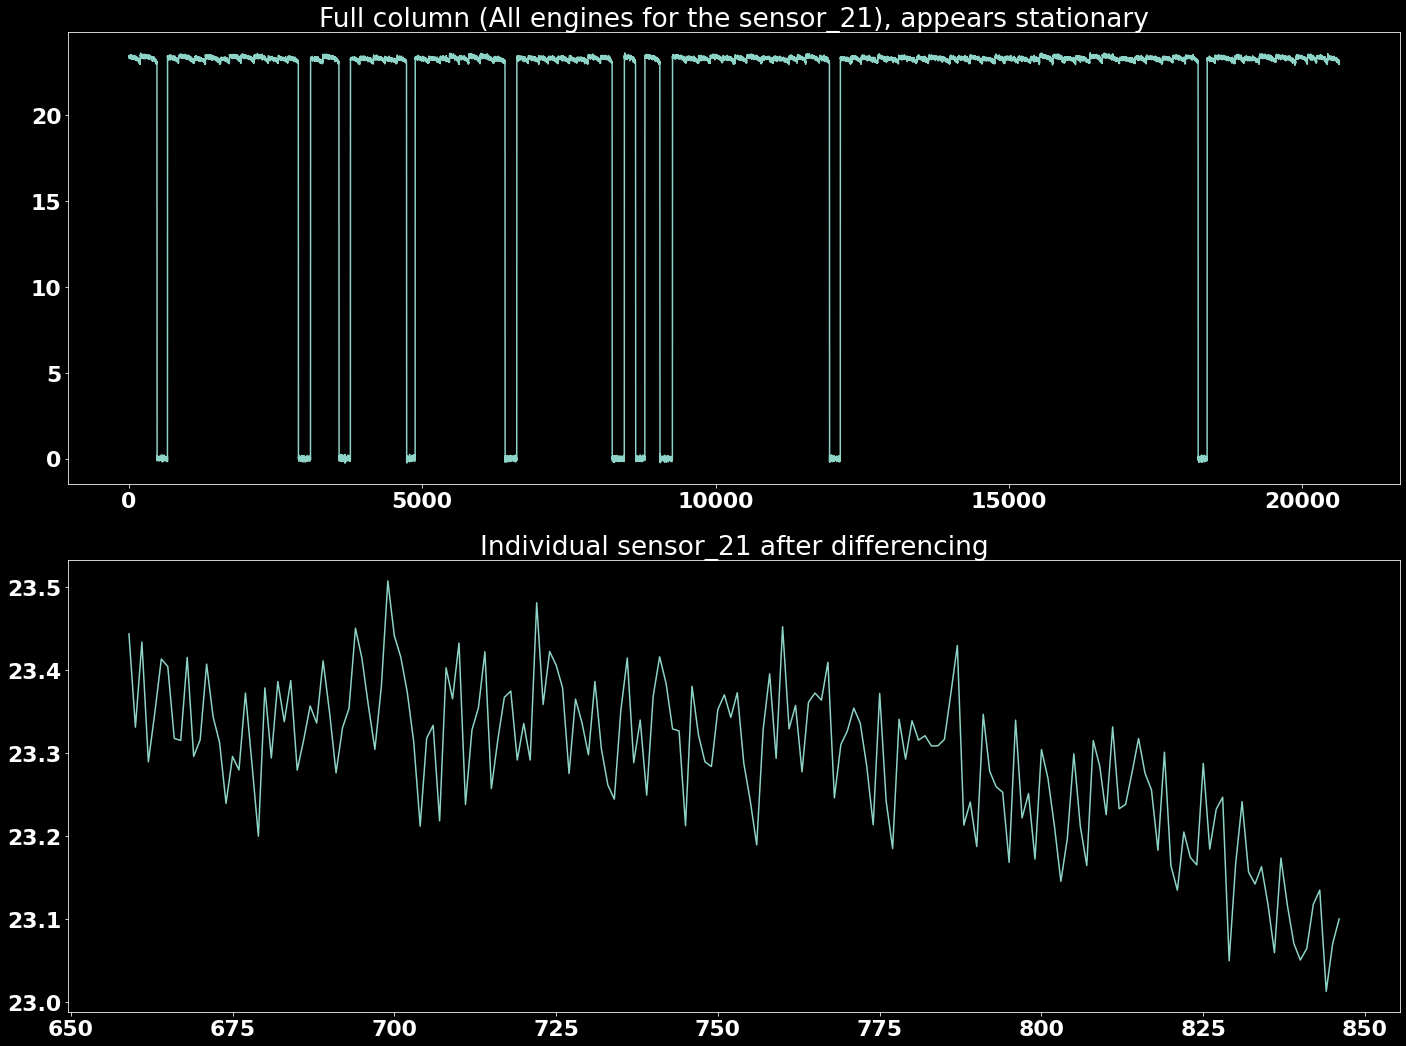

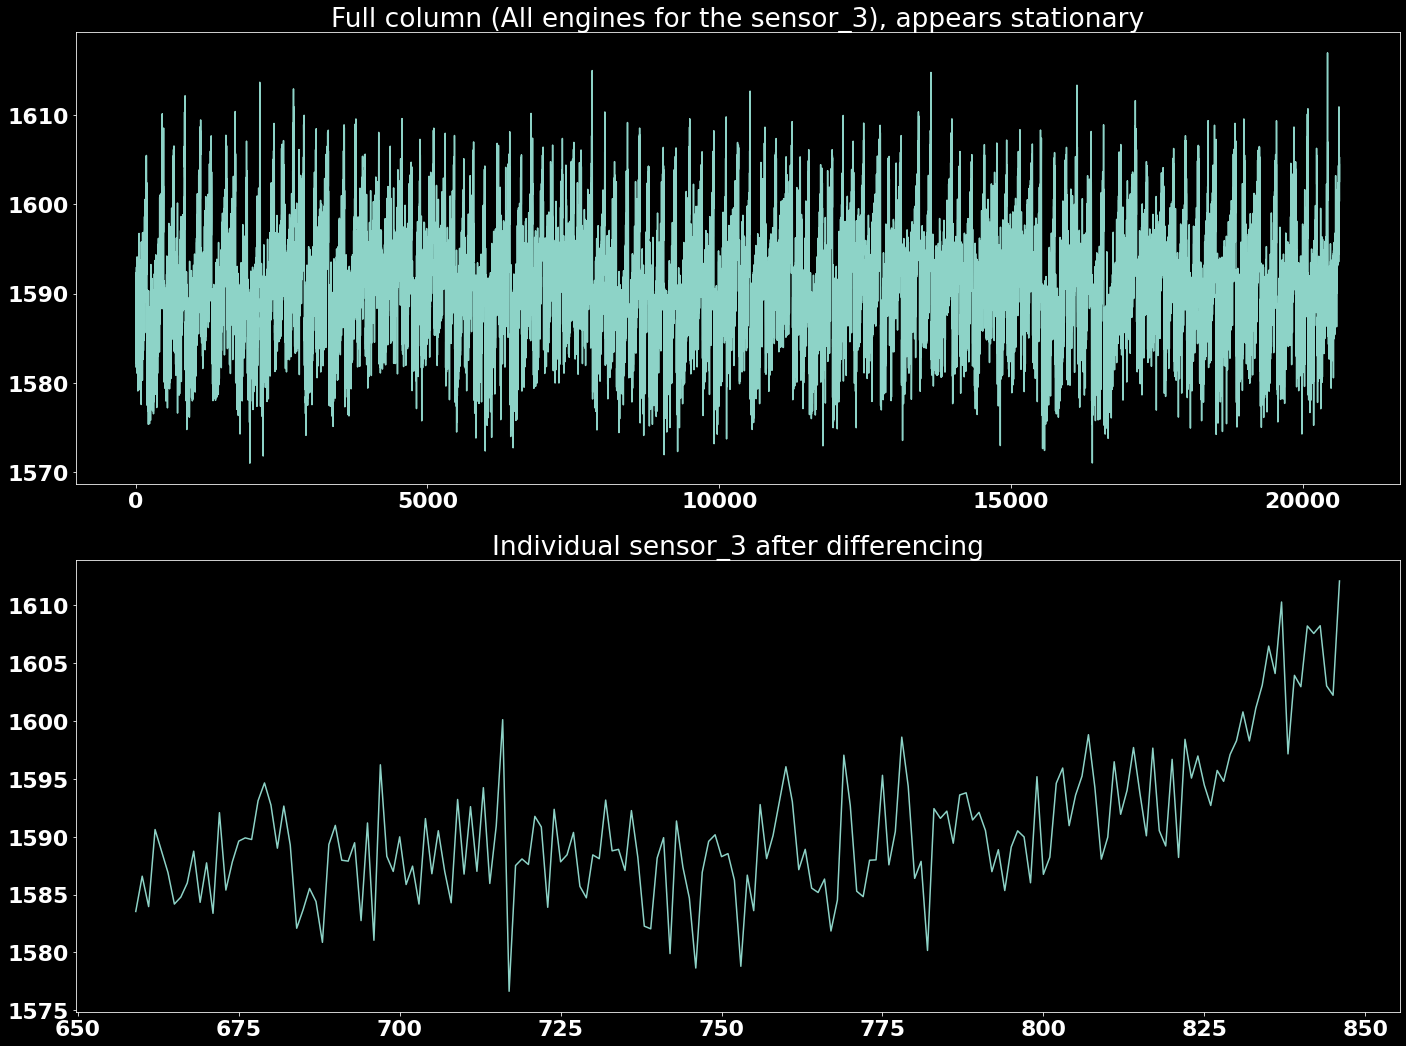

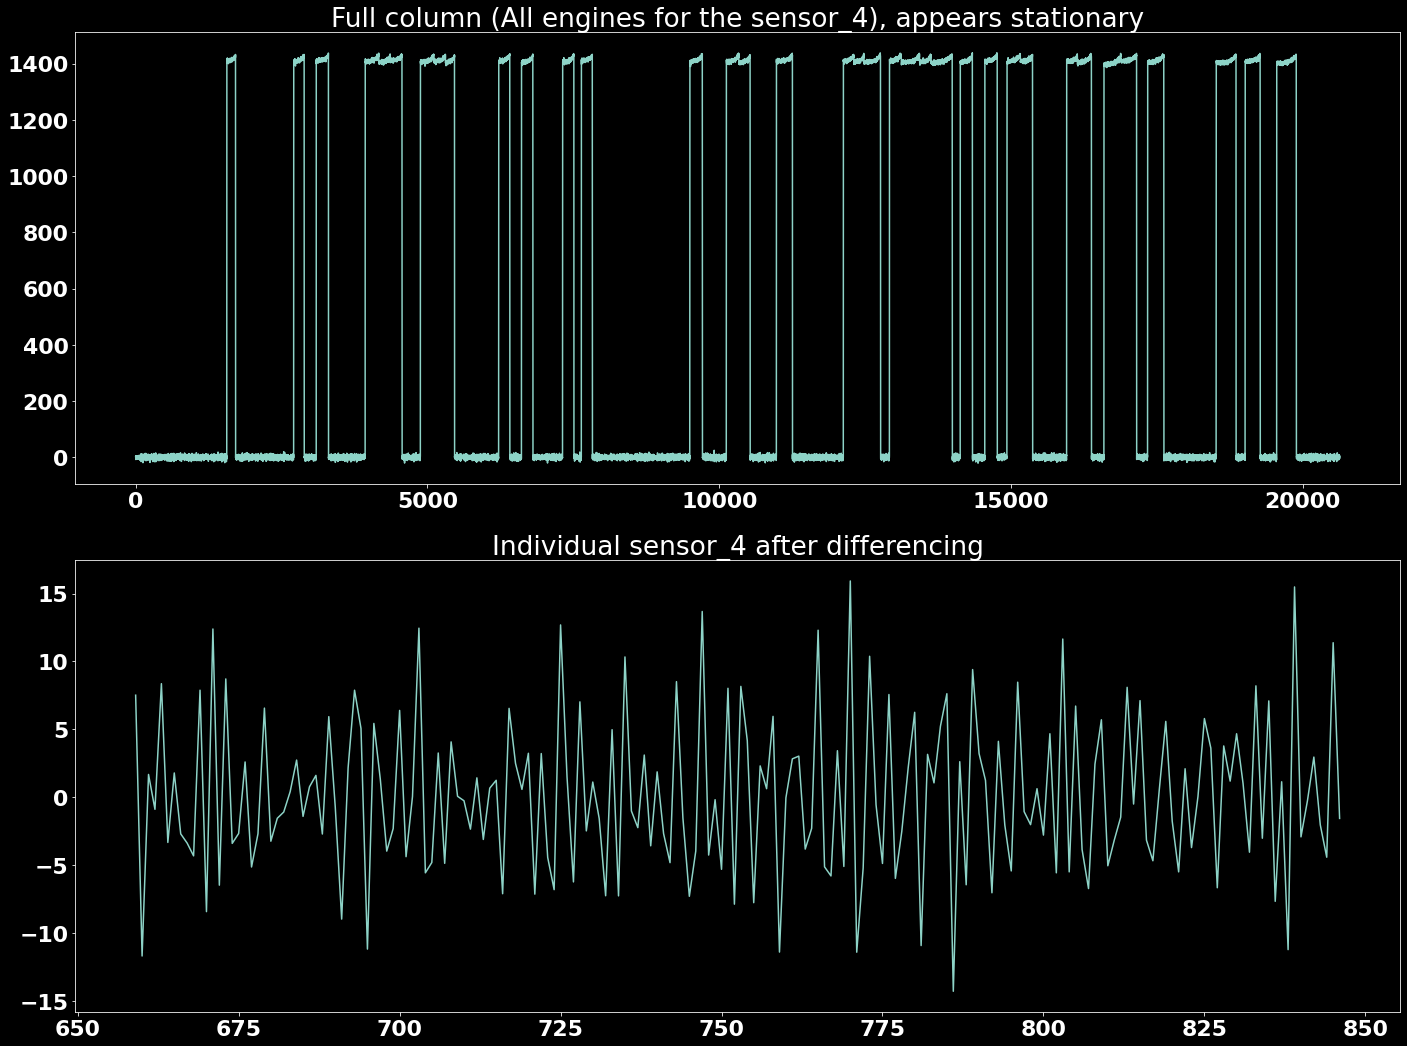

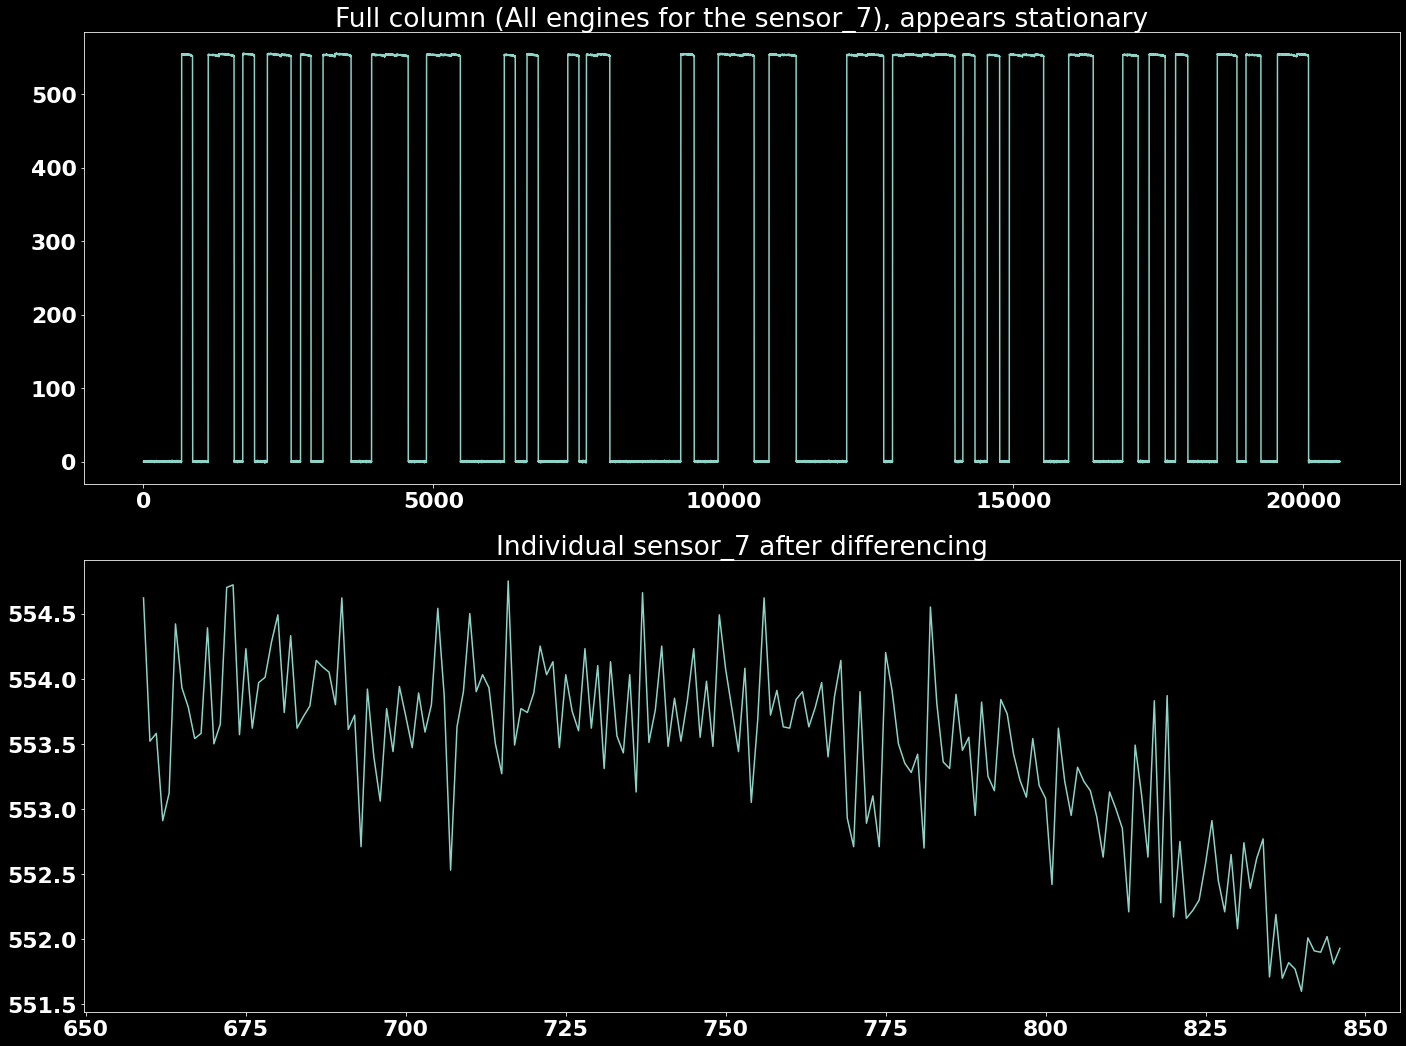

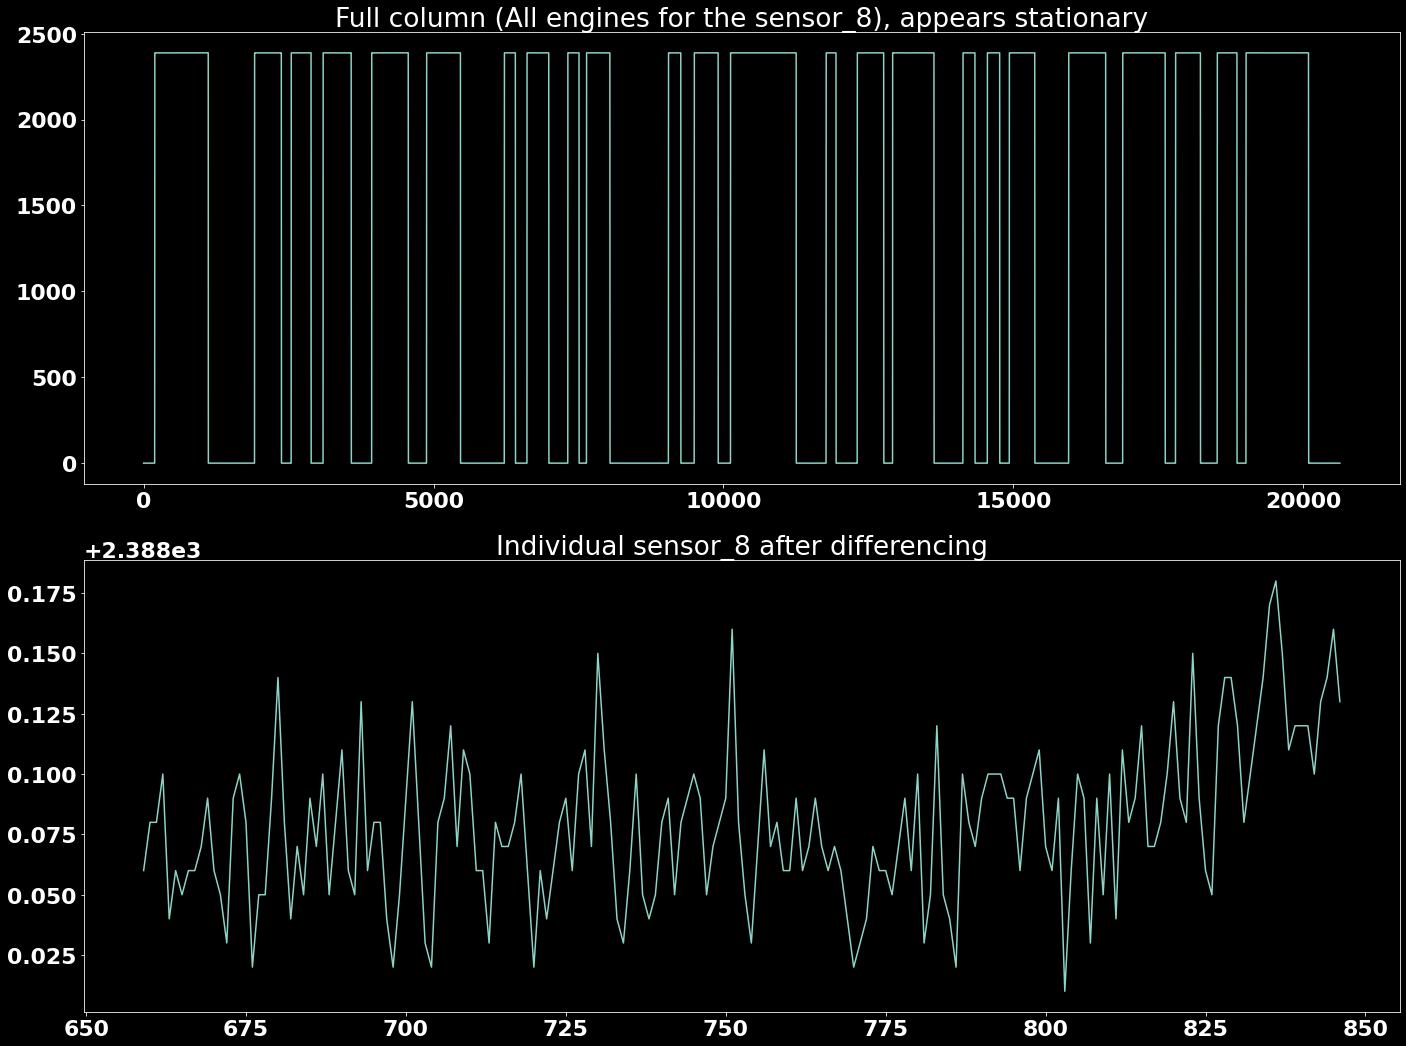

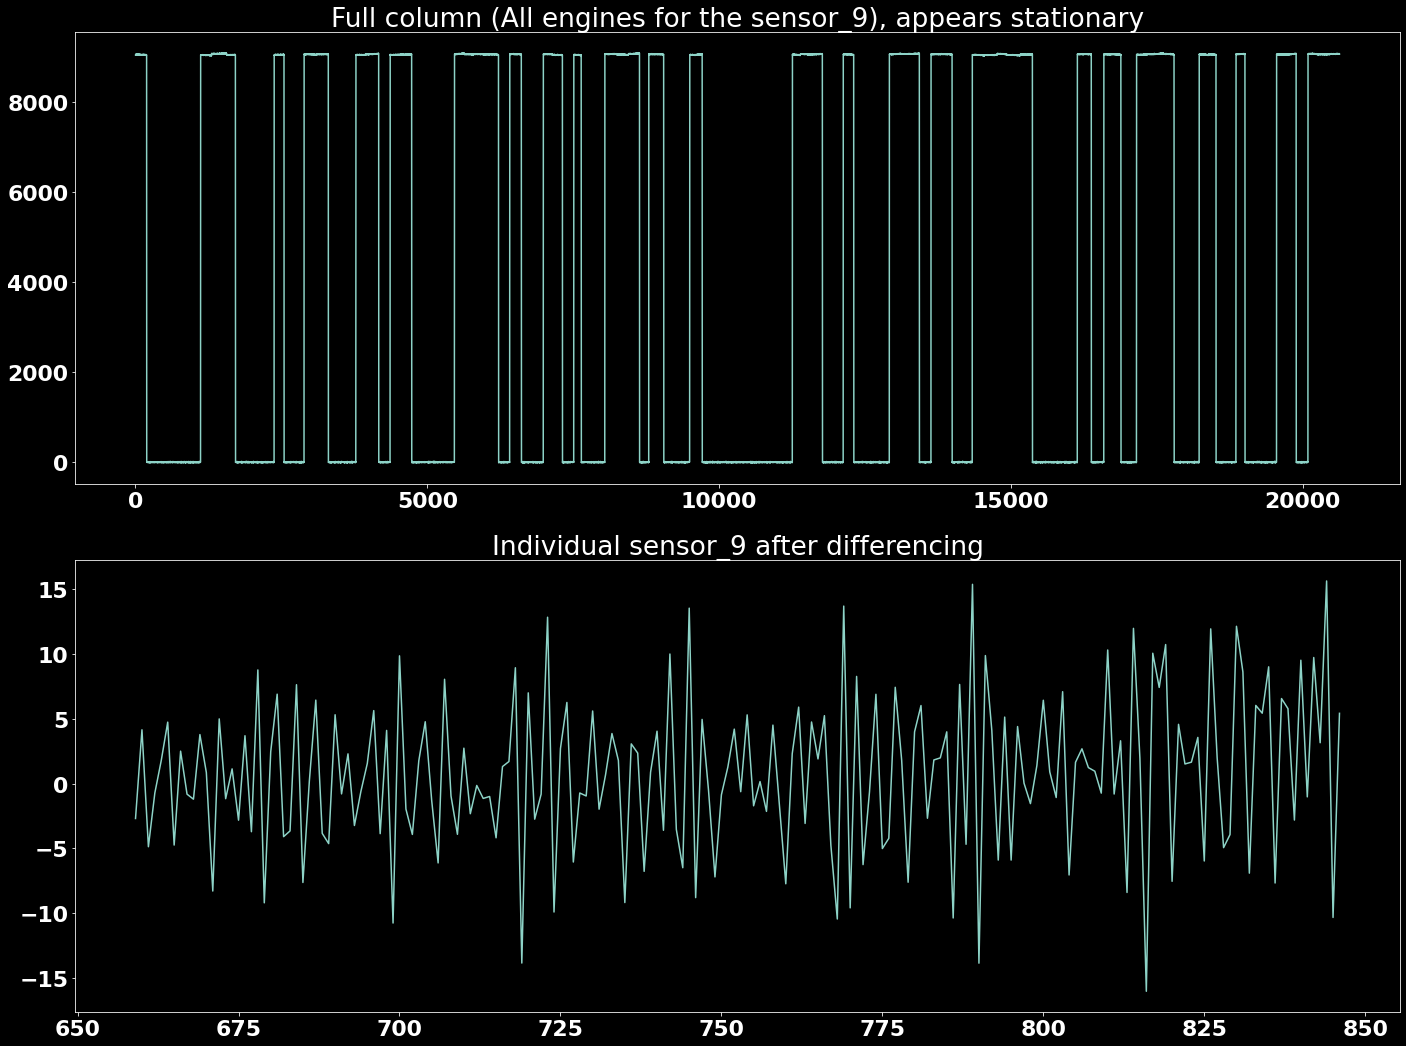

In [100]:
## Plot individual and all Engine sensor wise data after differencing
engine_id=4
for col in inter_col:
  plot_station(intermediate_df, engine_id, col)

<font color ="red">**Some sesor still have some trend and does not appear to be stationary**

## Fit a regression model after making the sensors stationary

In [101]:
# create and fit model
lm = LinearRegression()
lm.fit(intermediate_df[rem_sensors], intermediate_df['RUL'])


LinearRegression()

In [102]:
# predict and evaluate
y_hat_train = lm.predict(intermediate_df[rem_sensors])
evaluate(intermediate_df['RUL'], y_hat_train, 'train')

train set RMSE:51.63375613791181, Variance:0.4340864011385228


Training RMSE has become quite a bit worse as a result of making the data stationary. This can be explained by the data no longer having a trend, making it difficult to fit a regression line. Scores will improve again when adding lagged variables, as this will inform the model of the change of the sensor values over time



## AIC: searching for the correct number of lags

In [104]:
import statsmodels.api as sm

metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])

In [105]:
nr_of_lags = 30

In [108]:
def add_lagged_variables(df_input, nr_of_lags, columns):
    df = df_input.copy()
    for i in range(nr_of_lags):
        lagged_columns = [col + '_lag_{}'.format(i+1) for col in columns]
        df[lagged_columns] = df.groupby('id')[columns].shift(i+1)
    df.dropna(inplace=True)
    return df

In [109]:
metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, rem_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

display(metrics)

,rmse,AIC,BIC
0,51.652627,220271.65,220390.59
1,46.060503,214530.30,214760.12
2,43.058562,210753.82,211094.38
3,41.151503,207898.35,208349.51
4,39.833453,205574.27,206135.89
5,38.813294,203528.00,204199.94
6,37.986450,201667.95,202450.06
7,37.304649,199952.23,200844.37
8,36.723366,198338.72,199340.76
9,36.198014,196782.37,197894.15


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


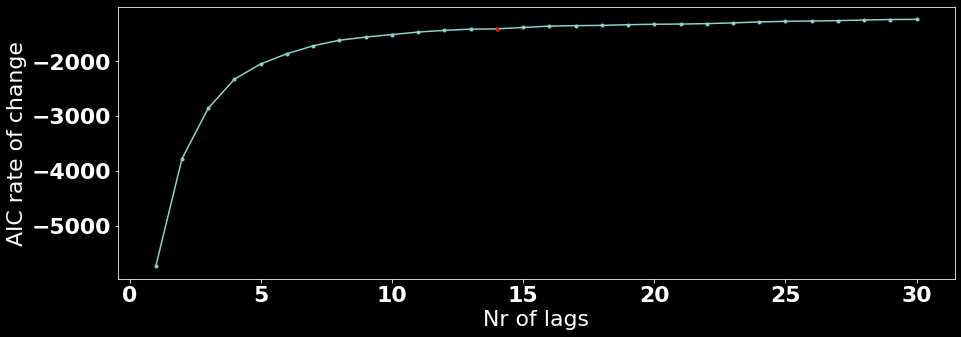

In [110]:
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(14, metrics['AIC'].diff()[14], '.r')
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

Based on the graph I'd say improvement stagnates at 13-14 lags.


In [111]:
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     136.9
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:16:41   Log-Likelihood:                -83949.
No. Observations:               17533   AIC:                         1.688e+05
Df Residuals:                   17098   BIC:                         1.721e+05
Df Model:                         434                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.908e+04    165.898    114.981      0.000    1.88e+04    1.94e+04
x1            -0.5162      0.722     -0.715      0.474      -1.931       0.899
x2            -0.3837      0.055     -6.974      0.000      -0.492      -0.276
x3            -0.2225      0.047     -4.728      0.000      -0.315      -0.130
x4             1.2576      0.471      2.671      0.008       0.335       2.180
x5            14.4389      6.395      2.258      0.024       1.904      26.974
x6            -0.0607      0.046     -1.325      0.185      -0.150       0.029
x7            -7.1442      1.865     -3.830      0.000     -10.800      -3.488
x8             1.5610      0.624      2.501      0.012       0.338       2.784
x9            12.0334      6.284      1.915      0.056      -0.284      24.351
x10            0.0454      0.059      0.764      0.445      -0.071       0.162
x11          -32.1409     10.207     -3.149      0.002     -52.148     -12.134
x12           -0.4505      0.228     -1.975      0.048      -0.897      -0.003
x13            3.2219      2.087      1.544      0.123      -0.869       7.313
x14            5.7930      3.539      1.637      0.102      -1.144      12.730
x15          -11.3690      2.129     -5.341      0.000     -15.541      -7.197
x16            2.2548      0.675      3.342      0.001       0.932       3.577
x17           13.9514      6.514      2.142      0.032       1.183      26.720
x18            0.0655      0.063      1.035      0.301      -0.059       0.190
x19          -31.2511     10.278     -3.041      0.002     -51.397     -11.106
x20           -0.4099      0.228     -1.797      0.072      -0.857       0.037
x21           -0.5227      0.723     -0.723      0.470      -1.939       0.894
x22            3.5827      2.090      1.714      0.087      -0.515       7.680
x23            5.4823      3.544      1.547      0.122      -1.464      12.429
x24           -0.3639      0.055     -6.605      0.000      -0.472      -0.256
x25           -0.3235      0.051     -6.390      0.000      -0.423      -0.224
x26            1.6130      0.494      3.263      0.001       0.644       2.582
x27           16.1230      6.638      2.429      0.015       3.112      29.134
x28           -0.0789      0.048     -1.633      0.103      -0.174       0.016
x29          -13.5609      2.187     -6.200      0.000     -17.848      -9.273
x30            2.6131      0.679      3.850      0.000       1.283       3.943
x31           12.4625      6.550      1.903      0.057      -0.377      25.302
x32            0.0639      0.064      1.003      0.316      -0.061       0.189
x33          -27.0154     10.276     -2.629      0.009     -47.157      -6.874
x34           -0.3297      0.228     -1.443      0.149      -0.777       0.118
x35           -0.8074      0.724     -1.116      0.264      -2.226       0.611
x3

## Multicolinearity

In [115]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler

In [116]:
scaler = StandardScaler()
scaler.fit(intermediate_df[rem_sensors])
intermediate_df[rem_sensors] = scaler.transform(intermediate_df[rem_sensors])

intermediate_df = make_stationary(intermediate_df, rem_sensors)

X_train = add_lagged_variables(intermediate_df, 14, rem_sensors)
X_train = X_train.drop(index_names, axis=1)

## Calculte Variance Inflation Factor

In [117]:
##Calculte VIF
vif_data = pd.DataFrame()

vif_data["Features"] = X_train.columns

In [120]:
vif(X_train.values,1)

2.209116404402726

In [122]:
vif_data["vif"] = [vif(X_train.values,i) for i in range(len(X_train.columns))]

In [135]:
vif_data

,Features,vif
0,sensor_2,8.693541e+04
1,sensor_3,2.209116e+00
2,sensor_4,2.062091e+04
3,sensor_7,3.303274e+05
4,sensor_8,1.091228e+09
...,...,...
206,sensor_3_lag_14,1.881230e+00
207,sensor_4_lag_14,2.072541e+04
208,sensor_7_lag_14,3.301793e+05
209,sensor_8_lag_14,1.106471e+09


In [133]:
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}

## Combine Predict and evaluate

In [136]:
## Combine Predict and evaluate
intermediate_df = train.drop(drop_labels, axis=1)
scaler = StandardScaler()
scaler.fit(intermediate_df[rem_sensors])
intermediate_df[rem_sensors] = scaler.transform(intermediate_df[rem_sensors])

In [138]:
intermediate_df = make_stationary(intermediate_df, rem_sensors)

In [139]:
metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, rem_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

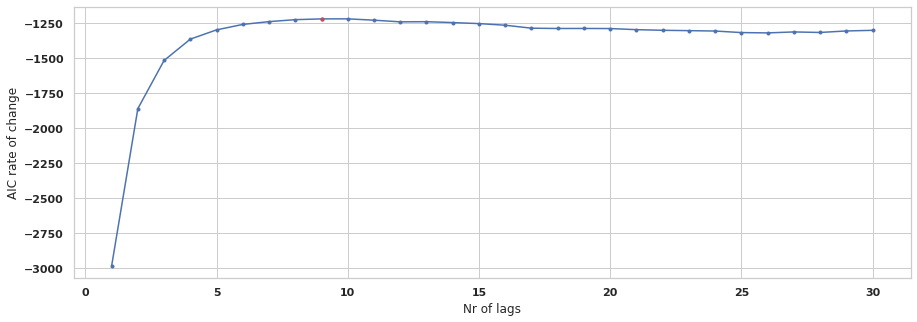

In [140]:
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(9, metrics['AIC'].diff()[9], '.r')
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

The point shifted a little, improvement stagnates at 9 lags instead of 14.

## Re-examine RUL
Our current assumption of RUL for the train set is that it declines linearly to zero. However, when we inspect the sensor signals they often show a 'bend' in their curve indicating degradation has started. Based on the information given to us we can't really say anything about RUL before this point, as we don't have any information on initial wear and tear of the engines.[Heimes 2008]
Therefore, we assume RUL to start out constant and only decline linearly after some time. The aim is to get a similar 'bend' in the curve (see image below).
Starting out with a constant RUL achieves two things:
1) Initially constant RUL correlates better with the stable mean sensor signal
2) Lower peak values of RUL results in lower spread of our target variable, making it easier to fit a line

In [143]:
lags = 9
# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[rem_sensors] = scaler.transform(X_train_interim[rem_sensors])
X_train_interim = make_stationary(X_train_interim, rem_sensors)
X_train_interim = add_lagged_variables(X_train_interim, lags, rem_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[rem_sensors] = scaler.transform(X_test_interim[rem_sensors])
X_test_interim = make_stationary(X_test_interim, rem_sensors)
X_test_interim = add_lagged_variables(X_test_interim, lags, rem_sensors)
X_test_interim = X_test_interim.groupby('id').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)  # apply clipped RUL from last post
model_fitted = model.fit()

In [145]:
# evaluate
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

train set RMSE:20.80233928213837, Variance:0.7523208224684111
test set RMSE:21.148958570124048, Variance:0.7409888687595036


**The distributed lag regression is much better than our traditional regression model where RMSE for test was aroung 31**.